# Predicting sales - Rossmann Kaggle competition

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.structured import *
from fastai.dataset import *
from fastai.column_data import *

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
import operator

In [3]:
PATH = "data/rossmann/"

## Get an overview over datasets

In [4]:
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test']

In [5]:
tables = [pd.read_csv(f'{PATH}{filename}.csv', low_memory=False) for filename in table_names]

In [6]:
for table in tables: display(table.head(2))

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


,Store,State
0,1,HE
1,2,TH


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0


### Look at summarized information of each table

In [7]:
for table in tables: display(DataFrameSummary(table).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


,StateName,State
count,16,16
unique,16,16
top,Sachsen,HE
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,...,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,...,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,...,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,...,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,...,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,...,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,...,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,...,24,32,24,44,29,47,41,9,21,362


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


## Data cleaning and feature engineering

In [8]:
train, store, store_states, state_names, googletrend, weather, test = tables

In [9]:
len(train), len(test)

(1017209, 41088)

### Convert *state holidays* to bool

In [10]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday =  test.StateHoliday!='0'

### Convenience function for joining tables
1. By default we do a left outer join of `right`on `left`
1. Naming convention for duplicate fields: add '_y' to the duplicate fields of the right table

In [11]:
def join_df(left, right, left_on, right_on = None, suffix = '_y'):
    if right_on is None:
        right_on = left_on
    return left.merge(right, how = 'left', left_on = left_on, right_on = right_on, suffixes=("", suffix))

### Join *weather* and *state names*

In [12]:
weather = join_df(weather, state_names, "file", "StateName")

### Extract *date* and *state name* from googletrends

In [13]:
googletrend.head(2)

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95


In [14]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]

In [15]:
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]

Replace all instanes of state name **NI** with **HB,NI** as used in the rest of the data. Background: The small city state *Hamburg* lies directly next to the state *Niedersachsen*.

In [16]:
googletrend.loc[googletrend.State=="NI", "State"] = 'HB,NI'

### Extract particular date fields from complete datetime in order to construct categoricals
**This is a crucial step because it allows capturing trend/cyclical behaviour as a function of time**

In [17]:
googletrend.columns

Index(['file', 'week', 'trend', 'Date', 'State'], dtype='object')

In [18]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date",drop=False)

In [19]:
googletrend.columns

Index(['file', 'week', 'trend', 'Date', 'State', 'Year', 'Month', 'Week',
       'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed'],
      dtype='object')

### Extract nation wide trend from *googletrend* 

In [20]:
trend_de = googletrend[googletrend.file == "Rossmann_DE"]

## Join data into a signle dataframe
**There are two ways to check for mistakes while joining:**
1. Do an **outer join** followed by a **null-check**
2. Do an **inner join** and compare the number of rows before and after

### Stores and states

In [21]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

### Stores

In [22]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]), len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

### Googletrend

In [23]:
joined = join_df(joined, googletrend, ["State", "Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State", "Year", "Week"])
len(joined[joined.trend.isnull()]), len(joined_test[joined_test.trend.isnull()])

(0, 0)

### Nationwide trend

In [24]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]), len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

### Weather

In [25]:
joined = join_df(joined, weather, ["State", "Date"])
joined_test = join_df(joined_test, weather, ["State", "Date"])
len(joined[joined.Max_TemperatureC.isnull()]), len(joined_test[joined_test.Max_TemperatureC.isnull()])

(0, 0)

### Delete duplicate columns

In [26]:
for dataframe in (joined, joined_test):
    for column in dataframe.columns:
        if column.endswith('_y'):
            # Some columns appear several times, 
            # maybe already deleted on first encounter, 
            # check if still exists:
            if column in dataframe.columns:
                dataframe.drop(column, inplace=True, axis=1)

## Handling of missing values

In [27]:
joined.columns[joined.isna().sum() != 0]

Index(['CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear',
       'PromoInterval', 'State_DE', 'Max_VisibilityKm', 'Mean_VisibilityKm',
       'Min_VisibilitykM', 'Max_Gust_SpeedKm_h', 'CloudCover', 'Events'],
      dtype='object')

Use *arbitrary signal value* that doesn't otherwise appear in the data.

In [28]:
for dataframe in (joined, joined_test):
    dataframe["CompetitionOpenSinceYear"] = dataframe.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    dataframe["CompetitionOpenSinceMonth"] = dataframe.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    dataframe["Promo2SinceYear"] = dataframe.Promo2SinceYear.fillna(1900).astype(np.int32)
    dataframe["Promo2SinceWeek"] = dataframe.Promo2SinceWeek.fillna(1).astype(np.int32)

In [29]:
len(joined[joined.Promo2SinceWeek.isnull()])

0

## Calculate how long the competition has been open

In [30]:
for dataframe in (joined, joined_test):
    dataframe["CompetitionOpenSince"] = pd.to_datetime(dict(year=dataframe.CompetitionOpenSinceYear,
                                                            month=dataframe.CompetitionOpenSinceMonth,
                                                            day=15))
    dataframe["CompetitionDaysOpen"] = dataframe.Date.subtract(dataframe.CompetitionOpenSince).dt.days

Replace erroneous or outlying data

In [31]:
for dataframe in (joined, joined_test):
    dataframe.loc[dataframe.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    dataframe.loc[dataframe.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

### Add a "CompetitionMonthsOpen" column, limiting the maximum to 24 months to reduce number of unique categories

In [32]:
for dataframe in (joined, joined_test):
    dataframe["CompetitionMonthsOpen"] = dataframe["CompetitionDaysOpen"]//30
    dataframe.loc[dataframe.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

### Calculate how long there has been a promotion

In [33]:
for dataframe in (joined, joined_test):
    dataframe["Promo2Since"] = pd.to_datetime(dataframe.apply(lambda x: Week(x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    dataframe["Promo2Days"] = dataframe.Date.subtract(dataframe["Promo2Since"]).dt.days

In [34]:
for dataframe in (joined, joined_test):
    dataframe.loc[dataframe.Promo2Days<0, "Promo2Days"] = 0
    dataframe.loc[dataframe.Promo2SinceYear<1990, "Promo2Days"] = 0
    dataframe["Promo2Weeks"] = dataframe["Promo2Days"]//7
    dataframe.loc[dataframe.Promo2Weeks<0, "Promo2Weeks"] = 0
    dataframe.loc[dataframe.Promo2Weeks>25, "Promo2Weeks"] = 25
joined.Promo2Weeks.unique()

array([ 0, 25, 17,  8, 13, 24, 16,  7, 12, 23, 15,  6, 11, 22, 14,  5, 10, 21,  4,  9, 20,  3, 19,  2, 18,
        1])

In [35]:
joined.to_feather(f'{PATH}joined')
joined.to_feather(f'{PATH}joined_test')

## Durations
Often, when working with time series data, we want to quantify relationships between rows as opposed to columns.

Examples:
1. Running averages
1. Time until next event
1. Time since last event

Let's define a function that keeps track of the last occurance of a given field:

In [36]:
def get_elapsed(df, fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []
    
    for s, v, d in zip(df.Store.values, df[fld].values, df.Date.values):
        # Assumes that you sort the dataframe by Store and Date
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        # Assumes that the function is applied to boolean columns 'fld'
        if v:
            last_date = d
        res.append(((abs(last_date - d)).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

We apply the function to the following columns:

In [37]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [38]:
df_train = train[columns]
df_test = test[columns]

### Proceed the following way:
1. Sort dataframe by *store* and *date*
1. If applied to column `SchoolHoliday`, adds a column with the number of days since last School Holiday
1. If we sort in ascending order, will add a column with number of days to next School Holiday

In [39]:
fld = 'SchoolHoliday'

### train dataframe
df_train = df_train.sort_values(['Store', 'Date'])
get_elapsed(df_train, fld, 'After')
df_train = df_train.sort_values(['Store', 'Date'], ascending = [True, False])
get_elapsed(df_train, fld, 'Before')

### test dataframe
df_test = df_test.sort_values(['Store', 'Date'])
get_elapsed(df_test, fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending = [True, False])
get_elapsed(df_test, fld, 'Before')

In [40]:
fld = 'StateHoliday'

### train dataframe
df_train = df_train.sort_values(['Store', 'Date'])
get_elapsed(df_train, fld, 'After')
df_train = df_train.sort_values(['Store', 'Date'], ascending = [True, False])
get_elapsed(df_train, fld, 'Before')

### test dataframe
df_test = df_test.sort_values(['Store', 'Date'])
get_elapsed(df_test, fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending = [True, False])
get_elapsed(df_test, fld, 'Before')

In [41]:
fld = 'Promo'

### train dataframe
df_train = df_train.sort_values(['Store', 'Date'])
get_elapsed(df_train, fld, 'After')
df_train = df_train.sort_values(['Store', 'Date'], ascending = [True, False])
get_elapsed(df_train, fld, 'Before')

### test dataframe
df_test = df_test.sort_values(['Store', 'Date'])
get_elapsed(df_test, fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending = [True, False])
get_elapsed(df_test, fld, 'Before')

Set active index to Date:

In [42]:
df_train = df_train.set_index("Date")
df_test = df_test.set_index("Date")

And set null values from *elapsed* fields to 0

In [43]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [44]:
for pre in ['Before', 'After']:
    for c in columns:
        a = pre + c
        df_train[a] = df_train[a].fillna(0).astype(int)
        df_test[a] = df_test[a].fillna(0).astype(int)

## Window functions to calculate rolling quantities
1. Sort by date (`sort_index()`)
1. Count the number of events defomed in `columns` in the following week (`rolling()`), grouped by Store
1. Do the same for the past week

In [45]:
bwd_train = df_train[['Store'] + columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
bwd_test = df_test[['Store'] + columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [46]:
fwd_train = df_train[['Store'] + columns].sort_index(ascending=False
                                                    ).groupby("Store").rolling(7, min_periods=1).sum()
fwd_test = df_test[['Store'] + columns].sort_index(ascending=False
                                                  ).groupby("Store").rolling(7, min_periods=1).sum()

**Drop the Store index**

In [47]:
bwd_train.drop("Store", 1, inplace=True)
bwd_test.drop("Store", 1, inplace=True)
fwd_train.drop("Store", 1, inplace=True)
fwd_test.drop("Store", 1, inplace=True)

bwd_train.reset_index(inplace=True)
bwd_test.reset_index(inplace=True)
fwd_train.reset_index(inplace=True)
fwd_test.reset_index(inplace=True)

df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

**Merge the dataframes together (SQL left outer join)**

In [48]:
df_train = df_train.merge(bwd_train, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_test = df_test.merge(bwd_test, 'left', ['Date', 'Store'], suffixes=['', '_bw'])

df_train = df_train.merge(fwd_train, 'left', ['Date', 'Store'], suffixes=['', '_fw'])
df_test = df_test.merge(fwd_test, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [49]:
df_train.drop(columns, 1, inplace=True)
df_test.drop(columns, 1, inplace=True)

In [50]:
df_train.head(2)

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-07-31,1,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2015-07-30,1,0,0,56,0,0,0,4.0,0.0,4.0,2.0,0.0,2.0


In [51]:
df_train.to_feather(f'{PATH}df_train')

In [52]:
df_test.to_feather(f'{PATH}df_test')

In [53]:
df_train = pd.read_feather(f'{PATH}df_train')

In [54]:
df_test = pd.read_feather(f'{PATH}df_test')

## Merge with the other dataframes

In [55]:
df_train['Date'] = pd.to_datetime(df_train.Date)

In [56]:
df_test['Date'] = pd.to_datetime(df_test.Date)

In [57]:
joined = join_df(joined, df_train, ['Store', 'Date'])
joined_test = join_df(joined_test, df_test, ['Store', 'Date'])

In [58]:
joined = joined[joined.Sales != 0]

In [59]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [60]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

**This is the final set of engineered features**

## Create features/inputs compatible with a neural network

In [61]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [62]:
joined.head().T.head(40)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


### Separate into continuos and categorical variables

**We treet `Year` etc. categorically even though it could be treated continuously. When there are only few distinct levels like years, categorical often works better.**

**Example:**
**The sales on different weekdays might behave categorically differently and might better not be described with a smooth continuous function.**

**Note, that all the cont. vars in this example are actual floating point numbers. Would be hard to make them cat. vars because there are too many distinct levels**

In [63]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [64]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [65]:
joined_test[dep] = 0
joined_test =  joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [66]:
for v in cat_vars:
    joined[v] = joined[v].astype('category').cat.as_ordered()

**Apply the same categories to the test dataframe**

In [67]:
for name, column in joined_test.items():
    if (name in joined.columns) and (joined[name].dtype.name=='category'):
        joined_test[name] = pd.Categorical(column, categories=joined[name].cat.categories, ordered=True)

**Convert continuous variables to int32**

In [68]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

**Create a smaller dataset for experimentation purposes**

In [69]:
n = len(joined);n

844338

In [70]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

**To use full dataset, run the follwing cell**

In [92]:
joined_samp = joined.set_index("Date")
samp_size = n

## Process data

In [93]:
joined_samp.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,2015,7,31,False,24,0,c,a,...,24.0,11.0,1.0,85.0,83.0,57.0,0.0,1.0,1.0,5263
2015-07-31,2,5,2015,7,31,False,24,25,a,a,...,14.0,11.0,4.0,80.0,83.0,67.0,0.0,1.0,1.0,6064


In [94]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)

In [95]:
yl = np.log(y)  #  We only did that because in that particular competition the eval metric used log

In [74]:
df_train = df_train.set_index("Date")
df_test = df_test.set_index("Date")

**Scale also the test data**

In [75]:
joined_test = joined_test.set_index("Date")


In [96]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'], mapper=mapper, na_dict=nas)

In [97]:
df.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,CompetitionDistance_na,CloudCover_na
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,3,7,31,1,25,1,3,1,...,-0.142774,-2.805667,1.732492,1.724334,0.604461,-1.111827,1.113717,2.04105,-0.050948,-0.29609
2015-07-31,2,5,3,7,31,1,25,26,1,1,...,-0.142774,-0.961766,1.294578,1.724334,0.926957,-1.111827,1.113717,2.04105,-0.050948,-0.29609


## Create validation set
**Good approach: use the exact same length time period as the test set uses because the Kaggle competition has the task to predict the next two weeks of sales.**

In [98]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

# Deep Learning
**Metric used by Kaggle for this competition: Root-mean-squared percent error**

In [99]:
def exp_rmspe(y_pred, targ):
    targ = np.exp(targ)
    pct_var = (targ - np.exp(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [100]:
y_range

(0, 12.7616122408592)

**Create a ModelData object**

In [101]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), 
                                       cat_flds=cat_vars, bs=128, test_df=df_test)

Let's take a look at the categorical variables. Note that especially `Store` hase a lot more categories than others.

In [102]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [103]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

The *cardinality* of each variable decides how large we make the respective *embedding*.

In [104]:
emb_szs = [(c, min(50, (c+1)//2)) for _, c in cat_sz]

In [105]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

In [86]:
m = md.get_learner(emb_szs=emb_szs, n_cont=len(df.columns) - len(cat_vars), 
                   emb_drop=0.04, out_sz=1, szs=[1000,500], drops=[0.001,0.01], y_range=y_range)
# out_sz Size of output
# szs Sizes of fully connected layers
# drops Dropout of fully connected layers

In [87]:
m.lr_find()

 66%|██████▌   | 738/1120 [00:09<00:04, 81.30it/s, loss=1.05]  


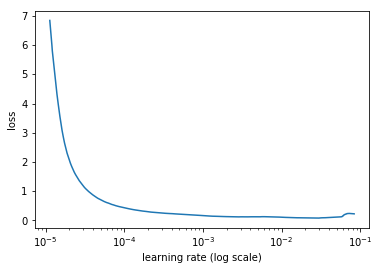

In [88]:
m.sched.plot()

## Sample

In [89]:
m = md.get_learner(emb_szs=emb_szs, n_cont=len(df.columns) - len(cat_vars), 
                   emb_drop=0.04, out_sz=1, szs=[1000,500], drops=[0.001,0.01], y_range=y_range)

In [90]:
lr = 1e-3

In [91]:
m.fit(lrs=lr, n_cycle=3, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.043861   0.049847   0.211041  
    1      0.031251   0.03819    0.183275                       
    2      0.019535   0.02644    0.149444                       



[array([0.02644]), 0.1494440686960171]

## All data

In [106]:
m = md.get_learner(emb_szs=emb_szs, n_cont=len(df.columns) - len(cat_vars), 
                   emb_drop=0.04, out_sz=1, szs=[1000,500], drops=[0.001,0.01], y_range=y_range)

In [107]:
m.fit(lr, 1, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.012623   0.022245   0.130642  



[array([0.02224]), 0.1306421457861451]

In [108]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.010807   0.013366   0.107339  
    1      0.009561   0.011874   0.104223                        
    2      0.008617   0.014081   0.107977                        



[array([0.01408]), 0.10797707133424034]

In [109]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.0069     0.010346   0.09649   
    1      0.007044   0.010406   0.096752                        
    2      0.006403   0.010465   0.096826                        



[array([0.01047]), 0.09682587512305003]

In [110]:
m.save('val0')

In [111]:
m.load('val0')

## Predictions

In [112]:
x, y = m.predict_with_targs()

In [113]:
exp_rmspe(x, y)

0.10041079504095173

In [114]:
pred_test = m.predict(is_test=True)

In [115]:
pred_test = np.exp(pred_test)

In [116]:
joined_test['Sales'] = pred_test

In [117]:
csv_preds = f'{PATH}tmp/sub.csv'

In [118]:
joined_test[['Id', 'Sales']].to_csv(csv_preds, index=False)

In [119]:
FileLink(csv_preds)

/home/fabiograetz/fastai/data/rossmann/tmp/sub.csv